<a href="https://colab.research.google.com/github/steveswo/ML-Invest/blob/main/ML_Invest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning in Investing 📉 📈**

In [5]:
# Install libraries
!pip install -r requirements.txt -q

import yfinance as yf   # Yahoo Finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from ta.momentum import RSIIndicator     # Technical Indicators Library
from ta.trend import MACD, SMAIndicator  # Technical Indicators Library

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


### 1. Data Cleaning

In [6]:
def cleaned_spy_data(start_date="2021-01-01", end_date="2025-12-31"):

    # 1. Download Data
    df = yf.download("SPY", start=start_date, end=end_date, progress=False, auto_adjust= True)
    print(f"--- 1. Raw Data Loaded ---")
    print(f"Shape: {df.shape}")

    # 2. Handle Multi index column
    print(f"\n--- 2. Multi index to single column---")
    print(f"Multi index column:")
    print(df.columns)
    df.columns = df.columns.get_level_values(0)
    print(f"\nChanged to single column:")
    print(f"Columns: {list(df.columns)}")

    # 3. Handle Duplicates
    df = pd.concat([df, df.iloc[[-1]]])  # Last row added to show logic works
    print(f"\n--- 3. Duplicates ---")
    print(f"Before dedup: {len(df)} rows")
    df = df[~df.index.duplicated(keep='first')]
    print(f"After dedup: {len(df)} rows")

    # 4. Handle Missing Values
    print(f"\n--- 4. Missing Values ---")
    df = df.ffill()
    print(f"Nulls after foward fill: {df.isnull().sum().sum()}")

    # 5. Handle Outliers
    returns = df['Close'].pct_change()
    lower_limit = returns.quantile(0.01)
    upper_limit = returns.quantile(0.99)

    print(f"\n--- 5. Outliers (Returns) ---")
    print(f"Max return before clip: {returns.max():.4%}")
    print(f"Min return before clip: {returns.min():.4%}")

    df['Clean_Returns'] = returns.clip(lower=lower_limit, upper=upper_limit)

    print(f"\nMax return after clip: {df['Clean_Returns'].max():.4%}")
    print(f"Min return after clip: {df['Clean_Returns'].min():.4%}")

    # 6. Final Cleanup
    df = df.dropna()
    print(f"\n--- 6. Final Dataset ---")
    print(df[['Close', 'Clean_Returns']].head())

    return df

# Run cleaning simulation
cleaned_data = cleaned_spy_data()

--- 1. Raw Data Loaded ---
Shape: (1254, 5)

--- 2. Multi index to single column---
Multi index column:
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])

Changed to single column:
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- 3. Duplicates ---
Before dedup: 1255 rows
After dedup: 1254 rows

--- 4. Missing Values ---
Nulls after foward fill: 0

--- 5. Outliers (Returns) ---
Max return before clip: 10.5019%
Min return before clip: -5.8543%

Max return after clip: 2.5826%
Min return after clip: -2.9294%

--- 6. Final Dataset ---
Price            Close  Clean_Returns
Date                                 
2021-01-05  346.627777       0.006887
2021-01-06  348.700104       0.005979
2021-01-07  353.880859       0.014857
2021-01-08  355.897186       0.005698
2021-01-11  353.498169      -0.006741


### 2. Exploratory Data Analysis and Feature Engineering

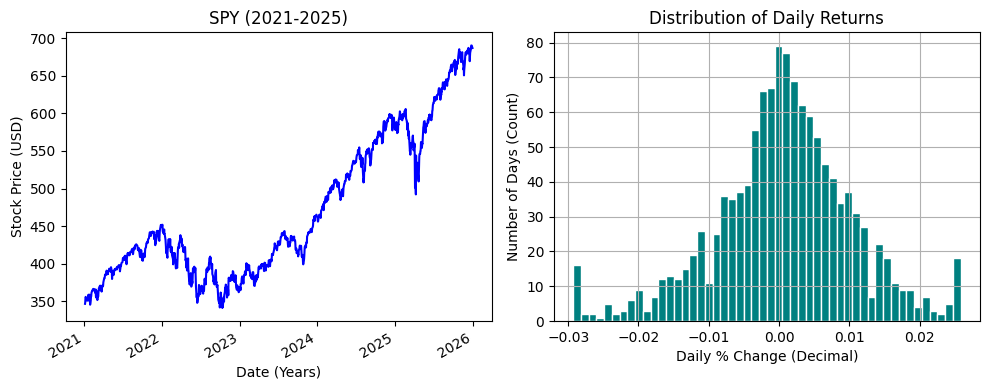

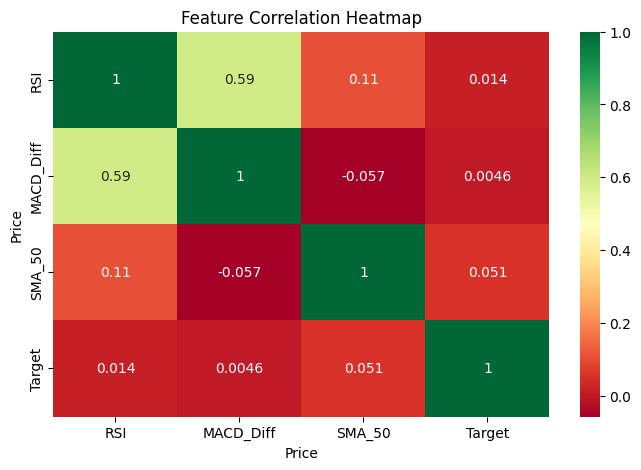

In [7]:
# --- INITIAL EDA ---
def initial_eda(df):
    plt.figure(figsize=(10, 4))

    # SPY Price Chart
    plt.subplot(1, 2, 1)
    df['Close'].plot(color='blue')
    plt.title('SPY (2021-2025)')
    plt.xlabel('Date (Years)')
    plt.ylabel('Stock Price (USD)')

    # Daily Returns Histogram
    plt.subplot(1, 2, 2)
    df['Clean_Returns'].hist(bins=50, color='teal', edgecolor='white')
    plt.title('Distribution of Daily Returns')
    plt.xlabel('Daily % Change (Decimal)')
    plt.ylabel('Number of Days (Count)')

    plt.tight_layout()
    plt.show()

# --- FEATURE ENGINEERING ---
def feature_engineering(df):
    df = df.copy()
    df['RSI'] = RSIIndicator(close=df['Close']).rsi()
    df['MACD_Diff'] = MACD(close=df['Close']).macd_diff()
    df['SMA_50'] = SMAIndicator(close=df['Close'], window=50).sma_indicator()

    # Predict if tomorrow is higher than today
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    return df.dropna()


initial_eda(cleaned_data)                     # Investigate raw data
df_final = feature_engineering(cleaned_data)  # Build signals

# --- POST-FEATURE EDA  ---
plt.figure(figsize=(8, 5))
sns.heatmap(df_final[['RSI', 'MACD_Diff', 'SMA_50', 'Target']].corr(), annot=True, cmap='RdYlGn')
plt.title('Feature Correlation Heatmap')
plt.show()

### 3. Primary & Comparison Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report

# 1. Prepare Features (X) and Target (y)
X = df_final[['RSI', 'MACD_Diff', 'SMA_50']]
y = df_final['Target']

# 2. Split to Training and Testing sets
split_index = int(len(df_final) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 3. Build Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# 4. Build Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

### 4. Results and Evaluation

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print("--- Model Performance (Year 2025 Test Period) ---\n")

# Generate Reports with zero_division fixed
print(f"{'='*30} RANDOM FOREST {'='*30}")
print(classification_report(y_test, rf_preds, zero_division=0)) # Zero division prevents model crash when predictions is zero

print(f"\n{'='*30} LOGISTIC REGRESSION (BASELINE) {'='*30}")
print(classification_report(y_test, lr_preds, zero_division=0))

--- Model Performance (Year 2025 Test Period) ---

============================== RANDOM FOREST ==============================
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       104
           1       0.56      0.49      0.52       137

    accuracy                           0.49       241
   macro avg       0.49      0.49      0.49       241
weighted avg       0.50      0.49      0.50       241


============================== LOGISTIC REGRESSION (BASELINE) ==============================
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.57      1.00      0.72       137

    accuracy                           0.57       241
   macro avg       0.28      0.50      0.36       241
weighted avg       0.32      0.57      0.41       241



0 represent 'Downtrend' days.
1 represent 'Uptrend' days.

**Logistic Regression:**
has higher accuracy (0.57), but its useless for risk management.

 It failed to predict a single "Downtrend" day, resulting in a 0.00 recall.

---

**Random Forest:**
Despite lower accuracy (0.49), it identified 0.51 (recall) of "Downtrend" days, providing the downside protection.

 0.56 precision on "Uptrend" days has a slight statistical edge over random 50 / 50 chance.

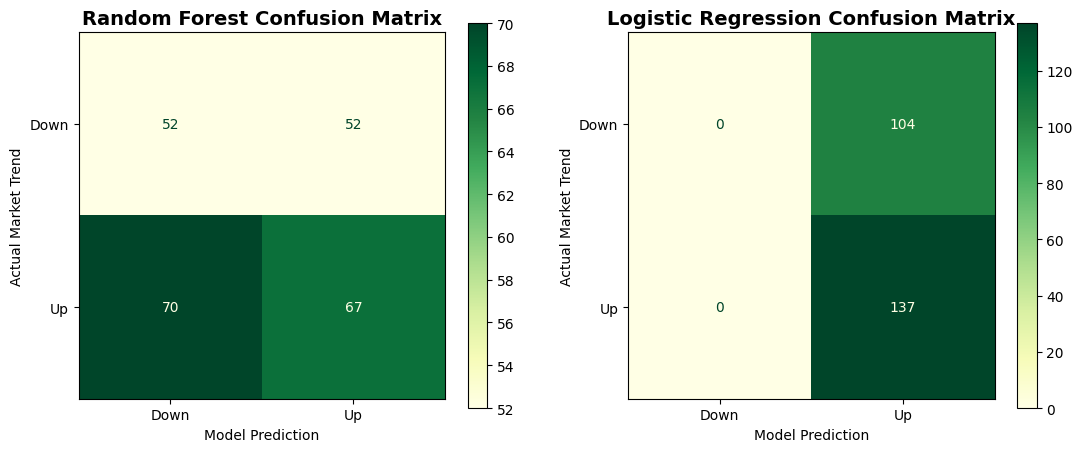

In [10]:
# Matrix Visuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Random Forest Matrix
cm_rf = confusion_matrix(y_test, rf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Down', 'Up'])
disp_rf.plot(ax=ax1, cmap='YlGn', colorbar=True)
ax1.set_title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
ax1.grid(False)
ax1.set_xlabel('Model Prediction')
ax1.set_ylabel('Actual Market Trend')

# Logistic Regression Matrix
cm_lr = confusion_matrix(y_test, lr_preds)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Down', 'Up'])
disp_lr.plot(ax=ax2, cmap='YlGn', colorbar=True)
ax2.set_title('Logistic Regression Confusion Matrix', fontsize=14, fontweight='bold')
ax2.grid(False)
ax2.set_xlabel('Model Prediction')
ax2.set_ylabel('Actual Market Trend')

plt.show()

The confusion matrix categorise every guess the model made during 2025 test period.

**True Positives (Bottom-Right)**: Correct "Uptrend" predictions. This is the profit engine.

**True Negatives (Top-Left)**: Correct "Downtrend" predictions. The model knew when not to invest and avoid losses.

**False Positives (Top-Right)**: The "False Alarm." The model suggest to Buy, but the market downtrend.

**False Negatives (Bottom-Left)**: Missed opportunities. The model was too cautious and stayed out during a market uptrend.


 The recent year of optimistic market sentiment with rising prices made Logistic Regression model default to predicting "Uptrend"  every day to maximise its accuracy score.
  
  The model never forecasts a market downtrend so the entire "Predicted Down" column results in 0 values for both True Negatives (Top-Left) and False Negatives (Bottom-Left).

 *Warning* : This is risky as the Logistic Regression model has always tells you to buy and has zero intelligence. In the event of a market crash, you'll lose your investments.

### 5. SHAP Explainability

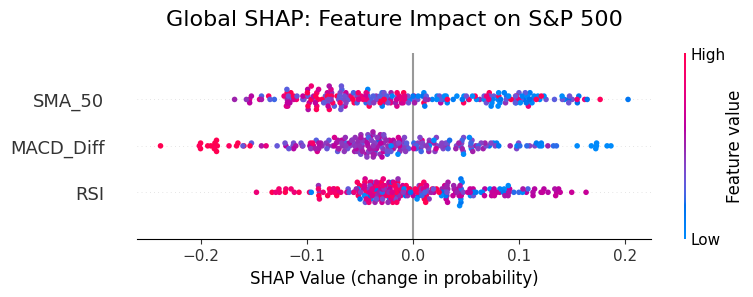

In [11]:
import shap

# GLOBAL SHAP
# Setup Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values_output = explainer.shap_values(X_test)

# Handle version differences for SHAP output shapes

if isinstance(shap_values_output, list):
    # Select index 1 for 'Uptrend' predictions
    correct_shap_values = shap_values_output[1]

else:
    # Newer versions return (samples, features, classes)
    correct_shap_values = shap_values_output[:, :, 1]

plt.figure(figsize=(10, 6))
shap.summary_plot(correct_shap_values, X_test, show=False)
plt.title('Global SHAP: Feature Impact on S&P 500', fontsize=16, pad=20)
plt.xlabel('SHAP Value (change in probability)', fontsize=12)
plt.show()

More red dots below 0.0 value indicate buying frenzy is over and price will downtrend*

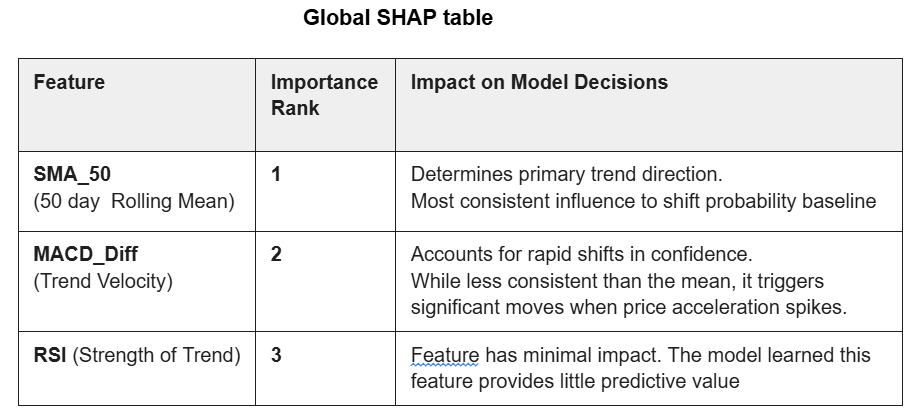

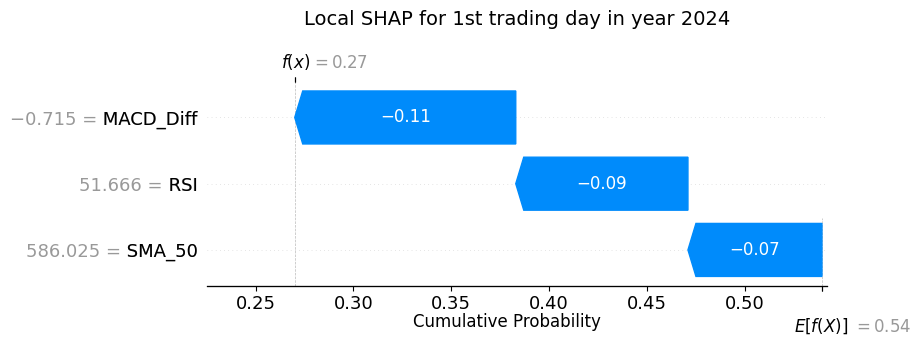

In [12]:
# LOCAL SHAP

exp_object = explainer(X_test)
fig = plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp_object[0, :, 1], show=False)
plt.title('Local SHAP for 1st trading day in year 2024\n', fontsize=14, pad=25)
fig.supxlabel('Cumulative Probability', fontsize=12, y=0.05)
plt.subplots_adjust(bottom=0.2)

plt.show()

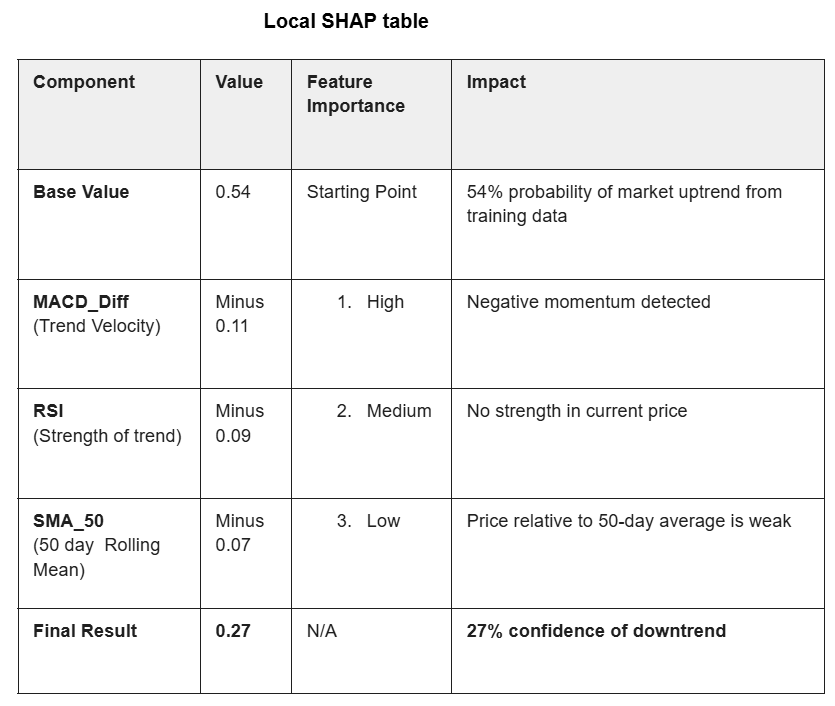

Global SHAP represents overall feature patterns learned from training data.
Local SHAP explains a specific day from the testing data.

Global SHAP shows MACD_Diff and SMA_50 as most influential drivers.

With 1 day (2nd January 2025) of testing data, Local SHAP confirm same features that reduced probability down to 0.27.

 This proves the model is stable.